In [1]:
import rasterio as rio
# from osgeo import gdal
import numpy as np
import os

# Cloud mask demo

## Description of the bits in the one-byte Quality Assessment layer

In [2]:
# Please look at the HLS user guide for more details
QA_BIT = {'cirrus': 0,
'cloud': 1,
'adj_cloud': 2,
'cloud shadow':3,
'snowice':4,
'water':5,
'aerosol_l': 6,
'aerosol_h': 7
}

## Raster IO functions

In [3]:
def read_img(img_path):
    with rio.open(img_path, 'r') as f:
        arr = f.read() # (bands, rows, columns)
    return arr

def get_img_profile(img_path):
    with rio.open(img_path, 'r') as f:
        return f.profile


def save_img_band(arr, out_path, dtype, profile):
    profile.update(
    dtype=dtype, #rio.uint8
    count=1,
    compress='lzw')

    with rio.open(out_path, 'w', **profile) as dst:
        dst.write(np.squeeze(arr).astype(dtype), 1)

## Demo of QA value to cloud mask

In [4]:
def test_mask(value, mask_list=['cloud', 'adj_cloud', 'cloud shadow', 'snowice', 'water', 'aerosol_high']):
    # This function takes a QA value and exports the desired mask value. 
    # The mask_list assigns the QA conditions you would like to mask.
    mask_img = 0
    for m in mask_list:
        if m in QA_BIT.keys():
            mask_img += (value & 1 << QA_BIT[m]) > 0
        if m == 'aerosol_high':
            mask_img += (value & (1 << QA_BIT['aerosol_h']) & (1 << QA_BIT['aerosol_l'])) > 0
        if m == 'aerosol_moderate':
            mask_img += (value & (1 << QA_BIT['aerosol_h']) & (0 << QA_BIT['aerosol_l'])) > 0
        if m == 'aerosol_low':
            mask_img += (value & (0 << QA_BIT['aerosol_h']) & (1 << QA_BIT['aerosol_l'])) > 0
    return mask_img > 0

test_vals = [64, 66,68, 194]
for val in test_vals:
    print('QA value and binary code: ', val, "{0:08b}".format(val))
    print('Mask: ', test_mask(val, mask_list=['cloud', 'adj_cloud', 'cloud shadow', 'snowice', 'water', 'aerosol_high']))

QA value and binary code:  64 01000000
Mask:  False
QA value and binary code:  66 01000010
Mask:  True
QA value and binary code:  68 01000100
Mask:  True
QA value and binary code:  194 11000010
Mask:  True


## HLS cloud mask function

In [5]:
def hls_mask(mask_img_path, mask_list=['cloud', 'adj_cloud', 'cloud shadow', 'snowice', 'water', 'aerosol_high']):
    # This function takes the HLS Fmask layer as input and exports the desired mask image array. 
    # The mask_list assigns the QA conditions you would like to mask.
    arr = read_img(mask_img_path)
    mask_img = np.zeros_like(arr)
    for m in mask_list:
        if m in QA_BIT.keys():
            mask_img += (arr & 1 << QA_BIT[m]) > 0
        if m == 'aerosol_high':
            mask_img += (arr & (1 << QA_BIT['aerosol_h']) & (1 << QA_BIT['aerosol_l'])) > 0
        if m == 'aerosol_moderate':
            mask_img += (arr & (1 << QA_BIT['aerosol_h']) & (0 << QA_BIT['aerosol_l'])) > 0
        if m == 'aerosol_low':
            mask_img += (arr & (0 << QA_BIT['aerosol_h']) & (1 << QA_BIT['aerosol_l'])) > 0
    return mask_img > 0

## Demo of HLS QA map to cloud  map map

Raw QA layer


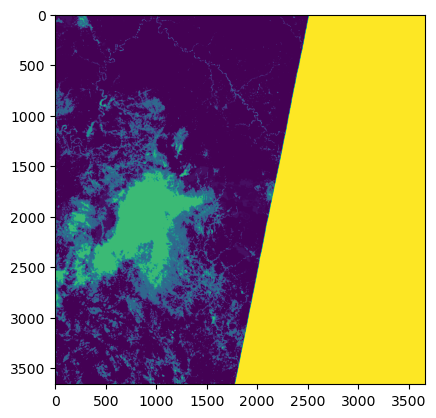

Cloud mask


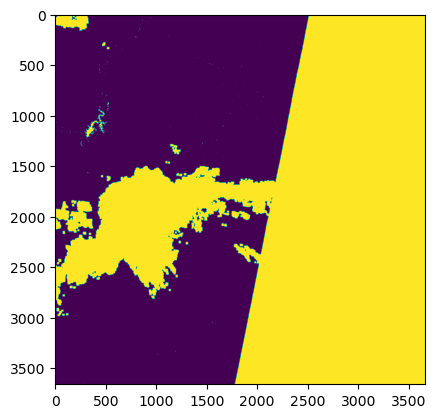

In [13]:
from matplotlib import pyplot
fmask_img = r'C:\Users\qzhou2\C_workdir\HLSdownload\HLS.L30.T12RZP.2021147T174059.v2.0.Fmask.tif'

src = rio.open(fmask_img)
print('Raw QA layer')
pyplot.imshow(src.read(1))
pyplot.show()

arr_mask = hls_mask(fmask_img)
out_path = os.path.join(os.path.dirname(fmask_img), 'cloud_mask.tif')
save_img_band(arr_mask, out_path, rio.uint8, get_img_profile(fmask_img))
src = rio.open(out_path)
print('Cloud mask')
pyplot.imshow(src.read(1))
pyplot.show()